In [154]:
import re
import json

import torch
from transformers import BertTokenizer
import pandas as pd
import numpy as np

import seaborn as sns

# Data

In [4]:
with open("../data/dev.json") as json_file:
    data = json.load(json_file)

In [14]:
print(data[0]['data']['text'])

PETITIONER:
THE COMMISSIONER OF INCOME-TAXNEW DELHI

Vs.

RESPONDENT:
M/s. CHUNI LAL MOONGA RAM

DATE OF JUDGMENT:
05/05/1961

BENCH:
DAS, S.K.
BENCH:
DAS, S.K.
HIDAYATULLAH, M.
SHAH, J.C.

CITATION:            1962 SCR (2) 823
 1962 AIR 1272

ACT:
Excess Profits Tax-Income-Assesseecarrying on business in
taxable territory-Losses incurred in transactionsin non-
taxable territory-If allowable in computing income-Excess
Profits Tax Act, 1940 (15 of 1940), s. 5.

HEADNOTE:
During the assessment year 1946-47, the assessee was
carrying on speculative business in bullion at Delhi. It
entered into transactions in the nature of forward
transactions with parties at Bhatinda (in the Patiala State
outside the taxable territories of British India) in which
it suffered losses. The assessee claimed deduction of these
losses in the computation of its income.
Held, that the losses incurred in Bhatinda could not be
taken into account in computing the income of the assessee
in British India. Under the t

In [15]:
len(data)

30

In [50]:
doc = data[0]['data']['text']
used = doc[:doc.rindex("ACT:")]
doc = doc[doc.rindex("ACT:"):]
print(used)
print("-----------------------------")
print(doc)

PETITIONER:
THE COMMISSIONER OF INCOME-TAXNEW DELHI

Vs.

RESPONDENT:
M/s. CHUNI LAL MOONGA RAM

DATE OF JUDGMENT:
05/05/1961

BENCH:
DAS, S.K.
BENCH:
DAS, S.K.
HIDAYATULLAH, M.
SHAH, J.C.

CITATION:            1962 SCR (2) 823
 1962 AIR 1272


-----------------------------
ACT:
Excess Profits Tax-Income-Assesseecarrying on business in
taxable territory-Losses incurred in transactionsin non-
taxable territory-If allowable in computing income-Excess
Profits Tax Act, 1940 (15 of 1940), s. 5.

HEADNOTE:
During the assessment year 1946-47, the assessee was
carrying on speculative business in bullion at Delhi. It
entered into transactions in the nature of forward
transactions with parties at Bhatinda (in the Patiala State
outside the taxable territories of British India) in which
it suffered losses. The assessee claimed deduction of these
losses in the computation of its income.
Held, that the losses incurred in Bhatinda could not be
taken into account in computing the income of the assesse

In [40]:
# def extract_sentences(text, start_text):
#     pattern = re.compile(rf'\b{re.escape(start_text)}.*?[.!?](?=\s|$)', re.IGNORECASE | re.DOTALL)
#     matches = re.findall(pattern, text)
#     return matches

# # Example usage:
# # text_to_search = "This is a sample text. Starting sentence with given text. Another sentence with the given text. Not starting with it."

# start_text = "CITATION"
# result = extract_sentences(doc, start_text)

In [51]:
data[0].keys()

dict_keys(['id', 'annotations', 'data', 'meta'])

In [53]:
len(data[0]['annotations'])

1

In [56]:
data[0]['annotations'][0].keys()

dict_keys(['result'])

In [58]:
len(data[0]['annotations'][0]['result'])

96

# Tokenizing

In [84]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(tokenizer)

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 5.88kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.12MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.56MB/s]
config.json: 100%|██████████| 570/570 [00:00<00:00, 558kB/s]

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [132]:
sent_id = []
sent_start = []
sent_end = []
train_sents = []
target = []
for entry in data:
    _ids, _start, _end, _text, _labels = [], [], [], [], []
    # print(entry)
    # print(entry['annotations'][0]['result'])
    # for x , y in [(data_point['text'], data_point['labels']) for data_point in entry['annotations'][0]['result']['value']]:
    for data_point in entry['annotations'][0]['result']:
        _ids.append(data_point['id'])
        _start.append(data_point['value']['start'])
        _end.append(data_point['value']['end'])
        _text.append(data_point['value']['text'])
        _labels.append(data_point['value']['labels'])
    
    sent_id.append(_ids)
    sent_start.append(_start)
    sent_end.append(_end)
    train_sents.append(_text)
    target.append(_labels)

In [134]:
try:
    doc_lens = []
    for doc_index, doc in enumerate(train_sents):
        sent_lens = []
        for sent_index, sentence in enumerate(doc):
            train_sents[doc_index][sent_index] = [tokenizer.cls_token] + tokenizer.tokenize(sentence) + [tokenizer.sep_token]
            sent_lens.append(len(train_sents[doc_index][sent_index]))    
        doc_lens.append(sent_lens)
    
except TypeError:
    print("Sentences already tokenized. Check again")

In [135]:
print(f"Number of documents : {len(train_sents)}")

Number of documents : 30


In [169]:
df = pd.DataFrame()
df['index'] = range(len(doc_lens))
df['lengths'] = doc_lens   
# for i in range(len(df)):
#     df['mean_length'] = np.mean(df['lengths'][i])
    

329


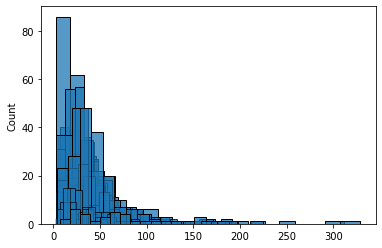

In [186]:
max_length = 0
for index, row in df.iterrows():
    sns.histplot(row['lengths'],bins=15)
    if np.max(row['lengths']) > max_length:
        max_length = np.max(row['lengths'])
        
print(max_length)

In [190]:
MAX_LENGTH = 330
# attention_matrix = np.zeros(train_sents)
for doc_index, doc in enumerate(train_sents):
    for sent_index, sentence in enumerate(doc):
        train_sents[doc_index][sent_index] = train_sents[doc_index][sent_index] + [tokenizer.pad_token for _ in range(MAX_LENGTH - len(train_sents[doc_index][sent_index]))]
        # for token in train_sents[doc_index][sent_index]:
        # attention_matrix[doc_index][sent_index] = [1 if token != tokenizer.pad_token else 0 for token in train_sents[doc_index][sent_index]]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.